In [89]:
import pandas as pd
import numpy as np
from io import StringIO
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
import requests
from sklearn.model_selection import train_test_split
from statistics import mean
import time
from io import StringIO
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from tqdm import tqdm
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import warnings
from collections import Counter
import pandas as pd
import pubchempy as pcp
from sklearn.metrics import jaccard_score
from itertools import combinations
import pubchempy as pcp
from collections import Counter
import numpy as np
from sklearn.metrics import jaccard_score
import requests
from tqdm import tqdm
import pandas as pd
from statistics import mean
from bs4 import BeautifulSoup
import json
import csv
from tqdm import tqdm
import pandas as pd 
from io import StringIO
from tqdm import tqdm
import itertools
from sklearn.model_selection import train_test_split
import re
#Ignore warning
import warnings
warnings.filterwarnings("ignore")
#Ignore warning
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import numpy as np 
#plotting packages
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure
import seaborn as sns
#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
#metrics
import math
from statistics import mean, stdev
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
# Ignore all warnings
warnings.filterwarnings('ignore')

  ### Outline
  
- [Methods](#0)
- [Loading Datasets](#1)
- [Evaluation](#3)
    - [Ratio 1:1](#3.1)
    - [Ratio 1:5](#3.2)        
    - [Ratio 1:10](#3.3)        

# 

<a name="0"></a>
**Methods**

In [90]:
def remove_labels_with_numbers(text):
    # Use a regular expression to remove numbers that appear as labels
    return re.sub(r'\d+', '', text)

In [91]:
def similarity_smile(smiles1,smiles2):
    score = 0
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    if mol1 is not None and mol2 is not None:
        fp1 = AllChem.GetMorganFingerprint(mol1, 2)  # Change radius as needed
        fp2 = AllChem.GetMorganFingerprint(mol2, 2)  # Change radius as needed
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        score = tanimoto_similarity
    else:
        score = -1
    return score

In [92]:
def generate_kmers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Function to count k-mers
def count_kmers(kmers):
    return Counter(kmers)

# Function to calculate similarity score
def calculate_similarity(seq1, seq2, k):
    kmers_seq1 = generate_kmers(seq1, k)
    kmers_seq2 = generate_kmers(seq2, k)
    
    count_kmers_seq1 = count_kmers(kmers_seq1)
    count_kmers_seq2 = count_kmers(kmers_seq2)
    
    common_kmers = set(count_kmers_seq1.keys()) & set(count_kmers_seq2.keys())
    common_count = sum(min(count_kmers_seq1[kmer], count_kmers_seq2[kmer]) for kmer in common_kmers)
    total_count = sum(count_kmers_seq1.values()) + sum(count_kmers_seq2.values())
    
    similarity = common_count / total_count
    return similarity

In [93]:
def generate_random_combinations(num_combinations, all_drugs, all_targets, df_original):
    # Generate all possible combinations
    all_combinations = pd.MultiIndex.from_product([all_targets, all_drugs], names=['Protein', 'Drug']).to_frame(index=False)
    
    # Drop combinations that are in the original DataFrame
    filtered_combinations = all_combinations[~all_combinations.set_index(['Protein', 'Drug']).index.isin(df_original.set_index(['Protein', 'Drug']).index)]
    
    # Sample randomly from the filtered combinations
    sampled_combinations = filtered_combinations.sample(n=num_combinations, random_state=42)
    
    # Create the label column
    sampled_combinations['Label'] = 0
    
    return sampled_combinations


In [94]:
def confusionMat_v2(Y_test, y_pred, y_prob, modelName):
    cf_matrix = confusion_matrix(Y_test, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    fpr, tpr, thresh = roc_curve(Y_test, y_prob, pos_label=1)
    auc = roc_auc_score(Y_test, y_prob)
    

    auprc = average_precision_score(Y_test, y_prob)
    precision_class0 = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[1, 0])
    recall_class0 = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[0, 1])

    precision_class1 = cf_matrix[1, 1] / (cf_matrix[1, 1] + cf_matrix[0, 1])
    recall_class1 = cf_matrix[1, 1] / (cf_matrix[1, 1] + cf_matrix[1, 0])

    accuracy = accuracy_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)

    print("\n", modelName, "...................................\n") 
    print("Accuracy:", accuracy)
    print("F1-Score:", f1)
    print("AUPRC:", auprc)
    print("AUROC:", auc)
    print("PrecisionClass0:", precision_class0)
    print("RecallClass0:", recall_class0)
    print("PrecisionClass1:", precision_class1)
    print("RecallClass1:", recall_class1)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax[0])
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
    print(classification_report(Y_test, y_pred, zero_division=1))
    return auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1,cf_matrix[1, 1]

In [95]:
columns = ['Data','AUPRC', 'AUROC', 'PrecisionClass0', 'RecallClass0', 'PrecisionClass1', 'RecallClass1', 'Accuracy', 'F1']
metricTable= pd.DataFrame(columns=columns)
metricTable

,Data,AUPRC,AUROC,PrecisionClass0,RecallClass0,PrecisionClass1,RecallClass1,Accuracy,F1


# 

<a name="1"></a>
**Loading Datasets**

- Mapping

In [96]:
mapping = pd.read_csv("../../../Dataset/Squad/IonChannels/drug_protein_interactions_Ion channel.csv")
mapping

,Protein,Drug
0,hsa11254,D00035
1,hsa6534,D00035
2,hsa11280,D00110
3,hsa6331,D00110
4,hsa6336,D00110
...,...,...
1471,hsa2557,D05461
1472,hsa2558,D05461
1473,hsa2559,D05461
1474,hsa2554,D06106


In [97]:
all_drugs = mapping['Drug'].unique().tolist()
all_targets = mapping['Protein'].unique().tolist()

- Features

In [46]:
# smile_drug = pd.read_csv("../../../Dataset/Squad/IonChannels/ID_drugs_df_Ion channel.csv", header=None, names=['Index', 'DrugID', 'SMILE'])
# smile_drug = smile_drug.drop("Index",axis=1)
# smile_drug.to_csv("../../../Dataset/Squad/IonChannels/drugs_smile.csv",index=False)

In [47]:
smile_drug = pd.read_csv("../../../Dataset/Squad/IonChannels/drugs_smile.csv")
smile_drug

,DrugID,SMILE
0,D00035,OC(=O)[C@@H]1CCCN1
1,D00110,[H][C@]12CC[C@]([H])([C@H]([C@H](C1)OC(=O)C1=C...
2,D00136,OC1(CCN(CCCC(=O)C2=CC=C(F)C=C2)CC1)C1=CC=C(Cl)...
3,D00195,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...
4,D00219,CC(=O)C1=CC=C(C=C1)S(=O)(=O)NC(=O)NC1CCCCC1
...,...,...
205,D05453,Cl.c1ccc(C2(N3CCCCC3)CCCCC2)cc1
206,D05458,CC(C)(N)CC1=CC=CC=C1
207,D05461,CCS(=O)(=O)C(C)C(=O)NC1=CC(=C(C=C1)C)F
208,D06106,CCCC(C)C1(CC=C)C(=O)NC(=S)NC1=O


In [13]:
# sequence_target = pd.read_csv("../../../Dataset/Squad/IonChannels/ID_targets_df_Ion channel.csv", header=None, names=['Index', 'TargetID', 'Sequence'])
# sequence_target = sequence_target.drop("Index",axis=1)
# sequence_target.to_csv("../../../Dataset/Squad/IonChannels/targets_sequence.csv",index=False)

In [50]:
sequence_target = pd.read_csv("../../../Dataset/Squad/IonChannels/targets_sequence.csv")
sequence_target

,TargetID,Sequence
0,hsa11254,MDKLKCPSFFKCREKEKVSASSENFHVGENDENQDRGNWSKKSDYL...
1,hsa6534,MKKLQGAHLRKPVTPDLLMTPSDQGDVDLDVDFAAHRGNWTGKLDF...
2,hsa11280,MDDRCYPVIFPDERNFRPFTSDSLAAIEKRIAIQKEKKKSKDQTGE...
3,hsa6331,MANFLLPRGTSSFRRFTRESLAAIEKRMAEKQARGSTTLQESREGL...
4,hsa6336,MEFPIGSLETNNFRRFTPESLVEIEKQIAAKQGTKKAREKHREQKD...
...,...,...
199,hsa2901,MPAELLLLLIVAFASPSCQVLSSLRMAAILDDQTVCGRGERLALAL...
200,hsa8001,MAHVRHFRTLVSGFYFWEAALLLSLVATKETDSARSRSAPMSPSDF...
201,hsa10060,MSLSFCGNNISSYNINDGVLQNSCFVDALNLVPHVFLLFITFPILF...
202,hsa2898,MKIIFPILSNPVFRRTVKLLLCLLWIGYSQGTTHVLRFGGIFEYVE...


**Similarity**

- Drug Similarity

In [15]:
data_drug = np.zeros((len(all_drugs), len(all_drugs)))
sim_SMILE = pd.DataFrame(data_drug, index=all_drugs, columns=all_drugs)
sim_SMILE

,D00035,D00110,D00136,D00195,D00219,D00225,D00227,D00228,D00234,D00252,...,D04985,D04999,D05024,D05077,D05156,D05453,D05458,D05461,D06106,D06172
D00035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D05453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D05458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D05461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D06106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
for id1 in tqdm(all_drugs, desc="Processing drugs smiles"):
    for id2 in all_drugs:
        smiles1 = smile_drug[smile_drug['DrugID'] == id1]['SMILE'].values[0]
        smiles2 = smile_drug[smile_drug['DrugID'] == id2]['SMILE'].values[0]
        score = similarity_smile(smiles1, smiles2)
        sim_SMILE.loc[id1][id2] = score
        sim_SMILE.loc[id2][id1] = score

sim_SMILE

Processing drugs smiles: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 210/210 [01:31<00:00,  2.29it/s]


,D00035,D00110,D00136,D00195,D00219,D00225,D00227,D00228,D00234,D00252,...,D04985,D04999,D05024,D05077,D05156,D05453,D05458,D05461,D06106,D06172
D00035,1.000000,0.105263,0.078652,0.061728,0.121622,0.011765,0.020202,0.060976,0.042735,0.042254,...,0.028571,0.224138,0.058824,0.058252,0.102941,0.054795,0.000000,0.045455,0.030769,0.053571
D00110,0.105263,1.000000,0.133333,0.200000,0.205882,0.155963,0.068182,0.144144,0.157143,0.175258,...,0.066667,0.305882,0.160839,0.192000,0.150000,0.181818,0.210526,0.123711,0.049020,0.137931
D00136,0.078652,0.133333,1.000000,0.150000,0.173913,0.189655,0.069930,0.230088,0.288889,0.188679,...,0.068966,0.138889,0.202703,0.248062,0.076271,0.172727,0.094737,0.130841,0.072072,0.110000
D00195,0.061728,0.200000,0.150000,1.000000,0.116071,0.113043,0.075188,0.141593,0.138889,0.104762,...,0.075472,0.141414,0.135135,0.135338,0.063636,0.133333,0.105882,0.099010,0.058252,0.109890
D00219,0.121622,0.205882,0.173913,0.116071,1.000000,0.106195,0.068702,0.125000,0.141844,0.130000,...,0.057143,0.222222,0.114865,0.174603,0.163265,0.160000,0.096386,0.186813,0.049505,0.139535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D05453,0.054795,0.181818,0.172727,0.133333,0.160000,0.155340,0.030769,0.188119,0.139706,0.150538,...,0.029412,0.238095,0.119718,0.154472,0.038462,1.000000,0.197183,0.062500,0.020408,0.082353
D05458,0.000000,0.210526,0.094737,0.105882,0.096386,0.189873,0.068627,0.144578,0.130435,0.205882,...,0.052632,0.234375,0.126050,0.135922,0.092105,0.197183,1.000000,0.132353,0.056338,0.175439
D05461,0.045455,0.123711,0.130841,0.099010,0.186813,0.110000,0.105263,0.087379,0.097015,0.125000,...,0.154762,0.129412,0.152672,0.185841,0.162791,0.062500,0.132353,1.000000,0.135802,0.333333
D06106,0.030769,0.049020,0.072072,0.058252,0.049505,0.038095,0.117117,0.037736,0.050725,0.043011,...,0.397059,0.056180,0.095588,0.081967,0.076923,0.020408,0.056338,0.135802,1.000000,0.108108


- Target Similarity 

In [48]:
data_targets = np.zeros((len(all_targets), len(all_targets)))
seq_SIM = pd.DataFrame(data_targets, index=all_targets, columns=all_targets)
seq_SIM

,hsa11254,hsa6534,hsa11280,hsa6331,hsa6336,hsa6529,hsa6530,hsa6531,hsa6532,hsa116444,...,hsa1140,hsa1144,hsa2895,hsa2899,hsa2900,hsa2901,hsa8001,hsa10060,hsa2898,hsa1181
hsa11254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa6534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa11280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa6331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa6336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa2901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa8001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa10060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa2898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
num_sequences = len(all_targets)
# Fill the similarity matrix
for i in tqdm(range(num_sequences), desc='Computing similarity matrix'):
    for j in range(i, num_sequences):
        seq1 = sequence_target.iloc[i]['Sequence']
        seq2 = sequence_target.iloc[j]['Sequence']
        
        # Perform global alignment
        alignments = pairwise2.align.globalxx(seq1, seq2)
        
        # Extract the alignment score (highest score)
        max_score = max(alignments, key=lambda x: x[2])[2]
        
        # Fill the matrix (symmetric matrix)
        seq_SIM.iloc[i, j] = max_score
        seq_SIM.iloc[j, i] = max_score

Computing similarity matrix: 100%|███████████████████████████████████████████████████████████████████████████████████████| 204/204 [26:29<00:00,  7.79s/it]


In [19]:
seq_SIM

,hsa11254,hsa6534,hsa11280,hsa6331,hsa6336,hsa6529,hsa6530,hsa6531,hsa6532,hsa116444,...,hsa1140,hsa1144,hsa2895,hsa2899,hsa2900,hsa2901,hsa8001,hsa10060,hsa2898,hsa1181
hsa11254,642.0,329.0,371.0,389.0,383.0,311.0,306.0,319.0,304.0,282.0,...,200.0,203.0,281.0,275.0,286.0,289.0,194.0,351.0,276.0,266.0
hsa6534,329.0,636.0,372.0,400.0,395.0,313.0,319.0,322.0,319.0,295.0,...,205.0,213.0,284.0,276.0,292.0,291.0,198.0,357.0,280.0,282.0
hsa11280,371.0,372.0,1791.0,1141.0,1134.0,351.0,370.0,373.0,368.0,482.0,...,314.0,326.0,485.0,459.0,467.0,479.0,306.0,610.0,451.0,452.0
hsa6331,389.0,400.0,1141.0,2016.0,1362.0,384.0,388.0,395.0,390.0,525.0,...,330.0,336.0,515.0,481.0,498.0,513.0,314.0,649.0,475.0,479.0
hsa6336,383.0,395.0,1134.0,1362.0,1956.0,377.0,383.0,387.0,388.0,507.0,...,331.0,334.0,506.0,485.0,488.0,496.0,311.0,643.0,482.0,472.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa2901,289.0,291.0,479.0,513.0,496.0,277.0,282.0,288.0,290.0,403.0,...,257.0,266.0,409.0,479.0,696.0,980.0,241.0,447.0,494.0,356.0
hsa8001,194.0,198.0,306.0,314.0,311.0,191.0,192.0,190.0,192.0,234.0,...,181.0,178.0,239.0,241.0,235.0,241.0,464.0,287.0,235.0,225.0
hsa10060,351.0,357.0,610.0,649.0,643.0,342.0,348.0,354.0,353.0,453.0,...,301.0,312.0,454.0,433.0,455.0,447.0,287.0,1549.0,430.0,432.0
hsa2898,276.0,280.0,451.0,475.0,482.0,268.0,273.0,276.0,276.0,371.0,...,240.0,243.0,398.0,727.0,473.0,494.0,235.0,430.0,908.0,328.0


In [20]:
k=1
kmer_1_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_1_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:43<00:00,  4.67it/s]


In [21]:
k=2
kmer_2_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_2_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


In [22]:
k=3
kmer_3_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_3_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.53it/s]


In [23]:
k=4
kmer_4_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_4_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.58it/s]


In [51]:
k=5
kmer_5_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_5_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:52<00:00,  3.90it/s]


In [68]:
k=6
kmer_6_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_6_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:54<00:00,  3.77it/s]


In [24]:
#Save Similarities
sim_SMILE.to_csv("../../../Dataset/Squad/IonChannels/Features/smile_similarity.csv")
seq_SIM.to_csv("../../../Dataset/Squad/IonChannels/Features/seq_SIM.csv")
kmer_1_similarity.to_csv("../../../Dataset/Squad/IonChannels/Features/kmer_1_similarity.csv")
kmer_2_similarity.to_csv("../../../Dataset/Squad/IonChannels/Features/kmer_2_similarity.csv")
kmer_3_similarity.to_csv("../../../Dataset/Squad/IonChannels/Features/kmer_3_similarity.csv")
kmer_4_similarity.to_csv("../../../Dataset/Squad/IonChannels/Features/kmer_4_similarity.csv")
kmer_5_similarity.to_csv("../../../Dataset/Squad/IonChannels/Features/kmer_5_similarity.csv")
kmer_6_similarity.to_csv("../../../Dataset/Squad/IonChannels/Features/kmer_6_similarity.csv")

**Loading Similarites**

In [98]:
#Load Similarities
sim_SMILE = pd.read_csv("../../../Dataset/Squad/IonChannels/Features/smile_similarity.csv")
default_protein   = pd.read_csv("../../../Dataset/Squad/IonChannels/Features/ic_simmat_dg.txt", delimiter='\t')
#SIMMAT
HLCS_simmat_dc         = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/HLCS_ic_simmat_dc.txt' , sep='\t')
NLCS_simmat_dc         = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/NLCS_ic_simmat_dc.txt' , sep='\t')
TFIDF_simmat_simmat_dc = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/TFIDF_ic_simmat_dc.txt' , sep='\t')
TF_simmat_simmat_dc    = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/TF_ic_simmat_dc.txt' , sep='\t')
complingo4_simmat_dc   = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/complingo4_ic_simmat_dc.txt' , sep='\t')
comptfidf_simmat_dc    = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/comptfidf_ic_simmat_dc.txt' , sep='\t')
edit_simmat_dc         = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/edit_ic_simmat_dc.txt' , sep='\t')
lingo3_simmat_dc       = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/lingo3_ic_simmat_dc.txt' , sep='\t')
lingo4_simmat_dc       = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/lingo4_ic_simmat_dc.txt' , sep='\t')
lingo5_simmat_dc       = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/lingo5_ic_simmat_dc.txt' , sep='\t')
smifp34Man             = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/smifp34Man_ic_simmat_dc.txt' , sep='\t')
smifp34Tan             = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/smifp34Tan_ic_simmat_dc.txt' , sep='\t')
smifp38Man             = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/smifp38Man_ic_simmat_dc.txt' , sep='\t')
smifp38Tan             = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/smifp38Tan_ic_simmat_dc.txt' , sep='\t')
substring              = pd.read_csv('../../../Dataset/Squad/IonChannels/Features/substring_ic_simmat_dc.txt' , sep='\t')
kmer_1_similarity = pd.read_csv("../../../Dataset/Squad/IonChannels/Features/kmer_1_similarity.csv")
kmer_2_similarity = pd.read_csv("../../../Dataset/Squad/IonChannels/Features/kmer_2_similarity.csv")
kmer_3_similarity = pd.read_csv("../../../Dataset/Squad/IonChannels/Features/kmer_3_similarity.csv")
kmer_4_similarity = pd.read_csv("../../../Dataset/Squad/IonChannels/Features/kmer_4_similarity.csv")
kmer_5_similarity = pd.read_csv("../../../Dataset/Squad/IonChannels/Features/kmer_5_similarity.csv")
kmer_6_similarity = pd.read_csv("../../../Dataset/Squad/IonChannels/Features/kmer_6_similarity.csv")


default_compound  = pd.read_csv("../../../Dataset/Squad/IonChannels/Features/ic_simmat_dc.txt", delimiter='\t')
seq_SIM   = pd.read_csv("../../../Dataset/Squad/IonChannels/Features/seq_SIM.csv")


In [99]:
comptfidf_simmat_dc.iloc[:, 1:] =  comptfidf_simmat_dc.iloc[:, 1:].applymap(lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x)

# 

<a name="3"></a>
### Evaluation

In [100]:
print("Dataset IonChannels with ", len(all_drugs) , " drugs and " , len(all_targets) , "targets including", len(mapping))

Dataset IonChannels with  210  drugs and  204 targets including 1476


In [101]:
#Random Negative Sampling 
mapping

,Protein,Drug
0,hsa11254,D00035
1,hsa6534,D00035
2,hsa11280,D00110
3,hsa6331,D00110
4,hsa6336,D00110
...,...,...
1471,hsa2557,D05461
1472,hsa2558,D05461
1473,hsa2559,D05461
1474,hsa2554,D06106


# 

<a name="3.1"></a>
### Ratio 1:1  
- [Evaluatuin](#3.1.0)
- [Feature Selection](#3.1.1)

In [167]:
mapping

,Protein,Drug
0,hsa11254,D00035
1,hsa6534,D00035
2,hsa11280,D00110
3,hsa6331,D00110
4,hsa6336,D00110
...,...,...
1471,hsa2557,D05461
1472,hsa2558,D05461
1473,hsa2559,D05461
1474,hsa2554,D06106


In [157]:
# Generate a DataFrame with 2926 random combinations
num_combinations = len(mapping)
df_random = generate_random_combinations(num_combinations, all_drugs, all_targets, mapping)
# Concatenate original DataFrame with the random combinations
mapping_all = pd.concat([mapping.assign(Label=1), df_random], ignore_index=True)
mapping_all = mapping_all.reset_index()
mapping_all

,index,Protein,Drug,Label
0,0,hsa11254,D00035,1
1,1,hsa6534,D00035,1
2,2,hsa11280,D00110,1
3,3,hsa6331,D00110,1
4,4,hsa6336,D00110,1
...,...,...,...,...
2947,2947,hsa2900,D02409,0
2948,2948,hsa6330,D03830,0
2949,2949,hsa2566,D02566,0
2950,2950,hsa6337,D05453,0


In [158]:
#Split Dataset
train_mapping, test_mapping = train_test_split(mapping_all, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [159]:
#Building up an empty dataframe for MiRAGE scores for each drug_disease pair 
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                   'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
                                    "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,   
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer6
                                  'kmer6_max','kmer6_mean',
                                  #Kmer5
                                  'kmer5_max','kmer5_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #Counts
                                  'count_drug','count_target','target'])
df_scores

,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,kmer2_mean,kmer1_max,kmer1_mean,default_protein_max,default_protein_mean,default_compound_max,default_compound_mean,count_drug,count_target,target


In [160]:
for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer6_max = 0
    kmer5_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
#     NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
    comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer6_mean = 0
    kmer5_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
#     NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
    comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    


    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
        comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])     

    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER6
        kmer6_max = max(kmer_6_similarity[kmer_6_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer6_mean = mean(kmer_6_similarity[kmer_6_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER5
        kmer5_max = max(kmer_5_similarity[kmer_5_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer5_mean = mean(kmer_5_similarity[kmer_5_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max  = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())

        
    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
                    comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer6
                    kmer6_max, kmer6_mean,
                    #Kmer5
                    kmer5_max, kmer5_mean,
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


2952it [01:49, 26.96it/s]                                                                                                                                  


In [161]:
df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_kmer5_max']     = df_scores['count_target'] * df_scores['kmer5_max']
df_scores['adj_kmer6_max']     = df_scores['count_target'] * df_scores['kmer6_max']

df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_comptfidf_max']         = df_scores['count_drug'] * df_scores['comptfidf_max']

df_scores['adj_comptfidf_mean']         = df_scores['count_drug'] * df_scores['comptfidf_mean']

df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_kmer5_mean']     = df_scores['count_target'] * df_scores['kmer5_mean']
df_scores['adj_kmer6_mean']     = df_scores['count_target'] * df_scores['kmer6_mean']


df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']

In [162]:
df_scores

,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
0,0,D00035,hsa11254,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,D00035,hsa6534,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,D00110,hsa11280,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,D00110,hsa6331,0.243243,0.149702,0.14942,0.089611,0.405,0.241163,0.21788,...,6.75255,0.97154,5.60989,4.27022,8.459473,4.016937,2.30139,1.600885,1.50842,14.93481
4,4,D00110,hsa6336,0.175824,0.13879,0.13468,0.085843,0.39405,0.230823,0.11903,...,3.92399,0.42249,3.02464,2.548625,5.02,2.354543,1.26469,0.821464,1.02605,9.19316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,2947,D02409,hsa2900,0.102804,0.102804,0.06056,0.06056,0.17647,0.17647,0.00055,...,0.17647,0.00055,0.06376,0.105475,0.254902,0.105769,0.03448,0.016667,0.03333,0.29296
2948,2948,D03830,hsa6330,0.304348,0.198101,0.08813,0.07005,0.25606,0.185684,0.20496,...,1.48547,0.4392,1.63566,1.259378,2.0125,1.013318,0.63485,0.396411,0.22641,3.14959
2949,2949,D02566,hsa2566,0.239583,0.14357,0.16825,0.107633,0.43369,0.273806,0.09709,...,2.73806,0.27255,2.04817,1.74398,3.522646,1.120819,0.76826,0.619937,0.57884,3.6066
2950,2950,D05453,hsa6337,0.195652,0.114087,0.14133,0.10038,0.32727,0.254953,0.06751,...,1.52972,0.15422,1.27919,0.780827,2.067548,0.827774,0.53635,0.375256,0.30867,2.61871


In [163]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

In [110]:
df_scores.columns

Index(['index', 'drugID', 'targetID', 'smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer6_max', 'kmer6_mean', 'kmer5_max', 'kmer5_mean', 'kmer4_max',
       'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max', 'kmer2_mean',
       'kmer1_max', 'kmer1_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 

In [111]:
features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer6_max', 'kmer6_mean', 'kmer5_max', 'kmer5_mean', 'kmer4_max',
       'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max', 'kmer2_mean',
       'kmer1_max', 'kmer1_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'adj_smile_max',
       'adj_sequence_max', 'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max',
       'adj_kmer4_max', 'adj_kmer5_max', 'adj_kmer6_max',
       'adj_default_protein_max', 'adj_default_compound_max', 'adj_HLCS_max',
       'adj_NLCS_max', 'adj_TFIDF_simmat_max', 'adj_TF_simmat_max',
       'adj_complingo_max', 'adj_edit_max', 'adj_lingo3_max', 'adj_lingo4_max',
       'adj_lingo5_max', 'adj_smifp34Man_max', 'adj_smifp34Tan_max',
       'adj_comptfidf_max', 'adj_comptfidf_mean', 'adj_smile_mean',
       'adj_sequence_mean', 'adj_kmer1_mean', 'adj_kmer2_mean',
       'adj_kmer3_mean', 'adj_kmer4_mean', 'adj_kmer5_mean', 'adj_kmer6_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_edit_mean',
       'adj_lingo3_mean', 'adj_lingo4_mean', 'adj_lingo5_mean',
       'adj_smifp34Man_mean', 'adj_smifp34Tan_mean']

Results of  Ion Channel 1:1

 RandomForest ...................................

Accuracy: 0.949238578680203
F1-Score: 0.9514563106796117
AUPRC: 0.9853764865875664
AUROC: 0.9798805695911805
PrecisionClass0: 0.9401408450704225
RecallClass0: 0.9535714285714286
PrecisionClass1: 0.9576547231270358
RecallClass1: 0.9453376205787781


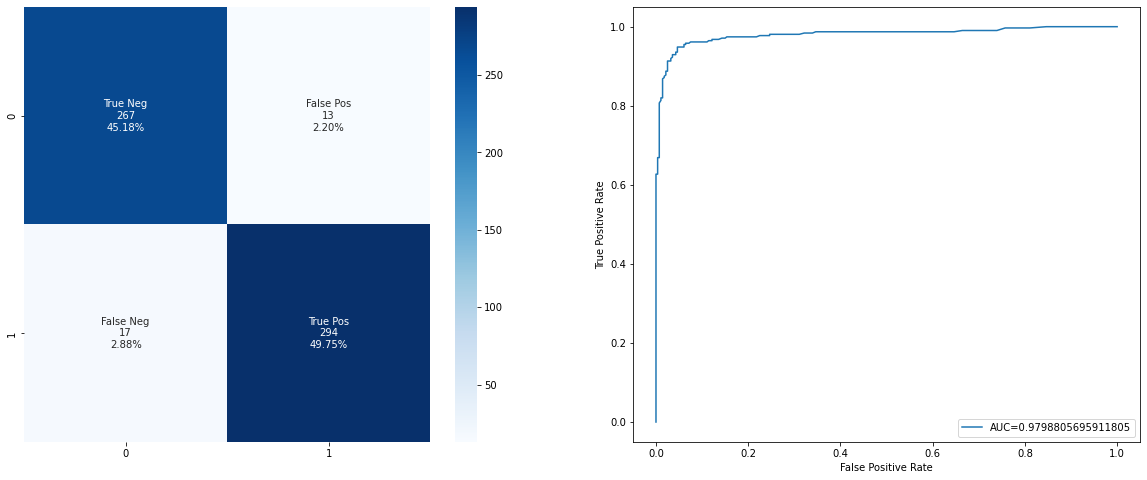

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       280
           1       0.96      0.95      0.95       311

    accuracy                           0.95       591
   macro avg       0.95      0.95      0.95       591
weighted avg       0.95      0.95      0.95       591



In [112]:
# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'Ion Channel 1:1'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

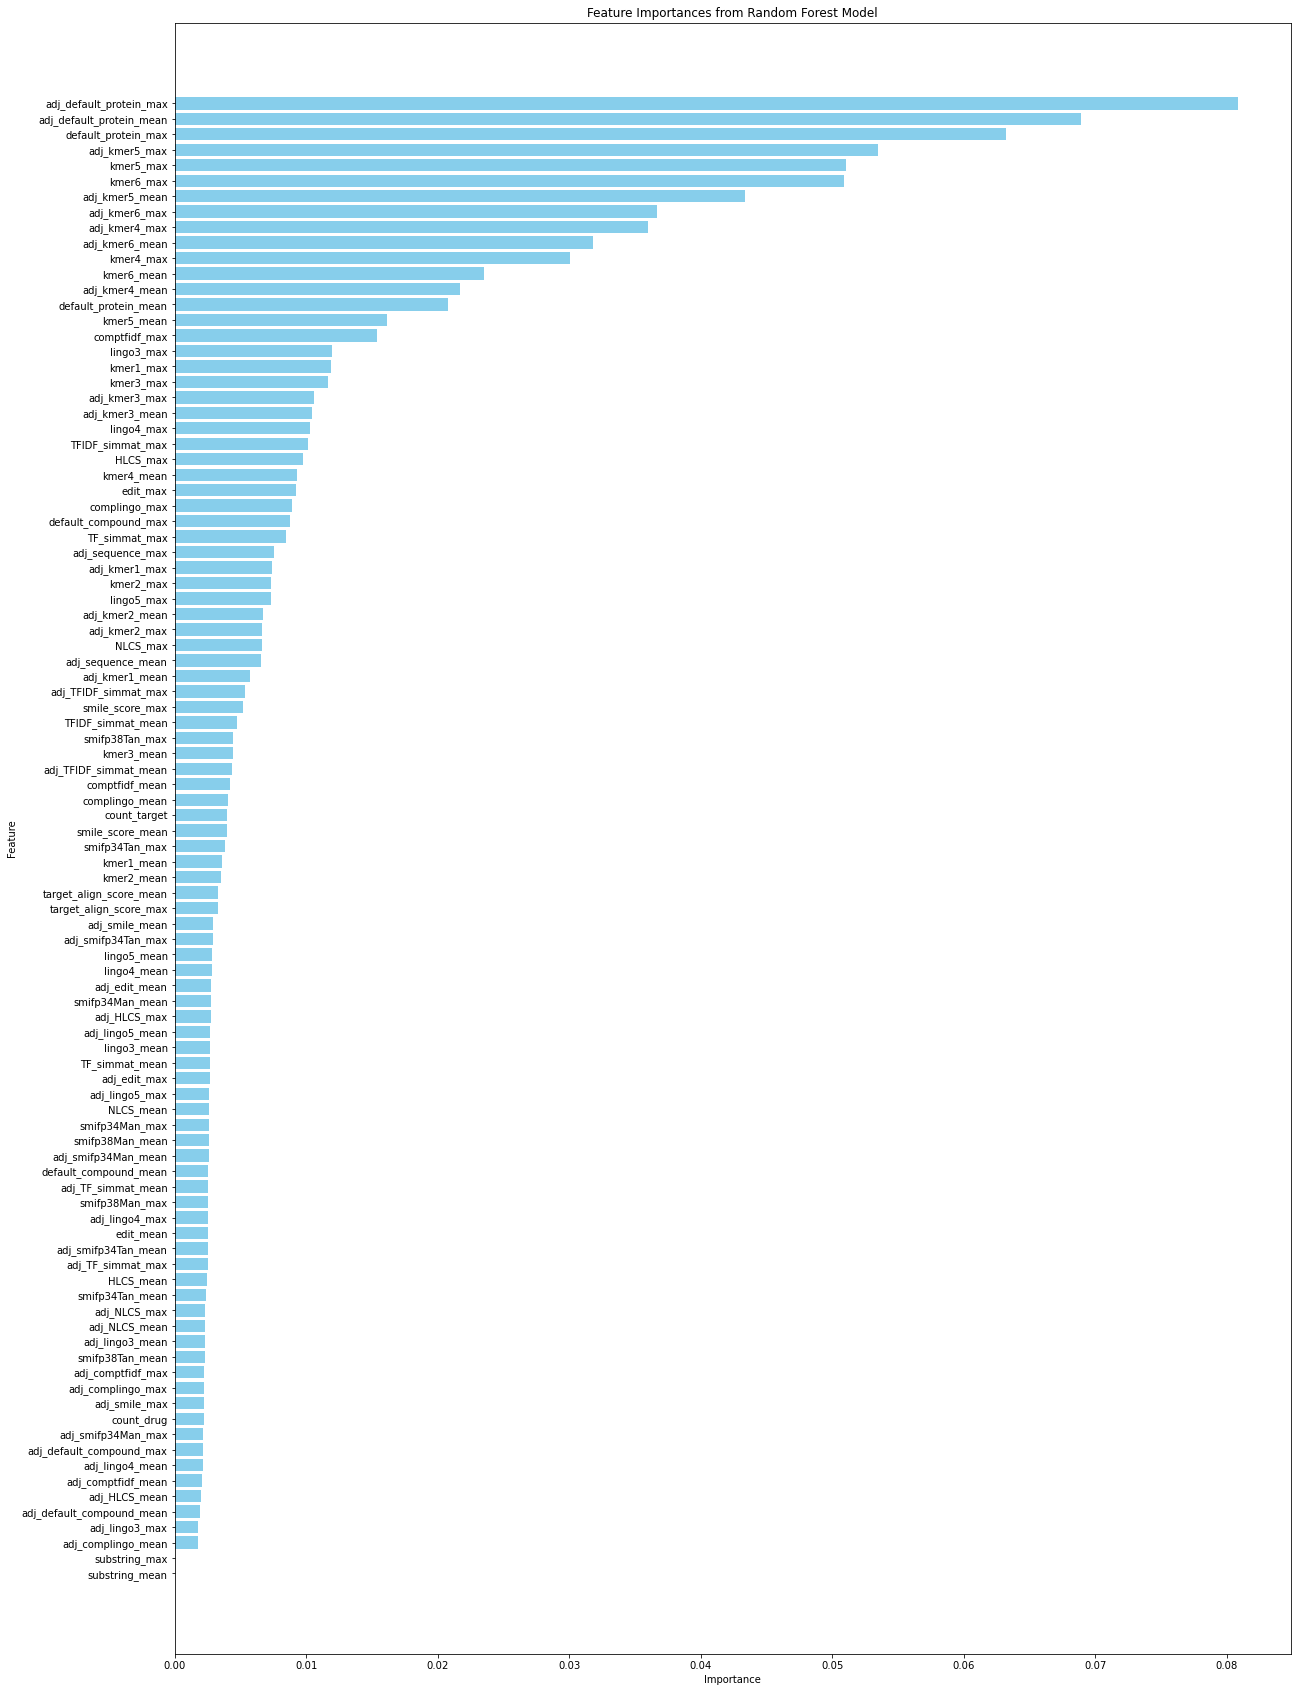

In [113]:
importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(20, 30))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [114]:
metricTable

,Data,AUPRC,AUROC,PrecisionClass0,RecallClass0,PrecisionClass1,RecallClass1,Accuracy,F1
0,Ion Channel 1:1,0.985376,0.979881,0.940141,0.953571,0.957655,0.945338,0.949239,0.951456


# 

### Feature Selection

In [115]:
selected_features = []
best_accuracy = 0  # Start with zero as the best accuracy

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred = rf.predict(X_test[temp_features])

        # Evaluate the model using accuracy
        current_accuracy = accuracy_score(y_test, y_pred)

        # If this model is better, select this feature
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - Accuracy: {best_accuracy}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final = rf_final.predict(X_test[selected_features])

# Evaluate the final model using accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with selected features: {final_accuracy}")

Added feature: kmer6_max - Accuracy: 0.8967851099830795
Added feature: lingo5_max - Accuracy: 0.9137055837563451
Added feature: smifp34Tan_max - Accuracy: 0.934010152284264
Added feature: adj_kmer2_max - Accuracy: 0.9441624365482234
Added feature: NLCS_max - Accuracy: 0.9543147208121827
Added feature: comptfidf_mean - Accuracy: 0.9560067681895094
Selected features: ['kmer6_max', 'lingo5_max', 'smifp34Tan_max', 'adj_kmer2_max', 'NLCS_max', 'comptfidf_mean']
Final Accuracy with selected features: 0.9560067681895094


Results of  Ion Channel 1:1 top_features

 RandomForest ...................................

Accuracy: 0.9560067681895094
F1-Score: 0.9577922077922078
AUPRC: 0.9844023774282232
AUROC: 0.9825103353238401
PrecisionClass0: 0.9440559440559441
RecallClass0: 0.9642857142857143
PrecisionClass1: 0.9672131147540983
RecallClass1: 0.9485530546623794


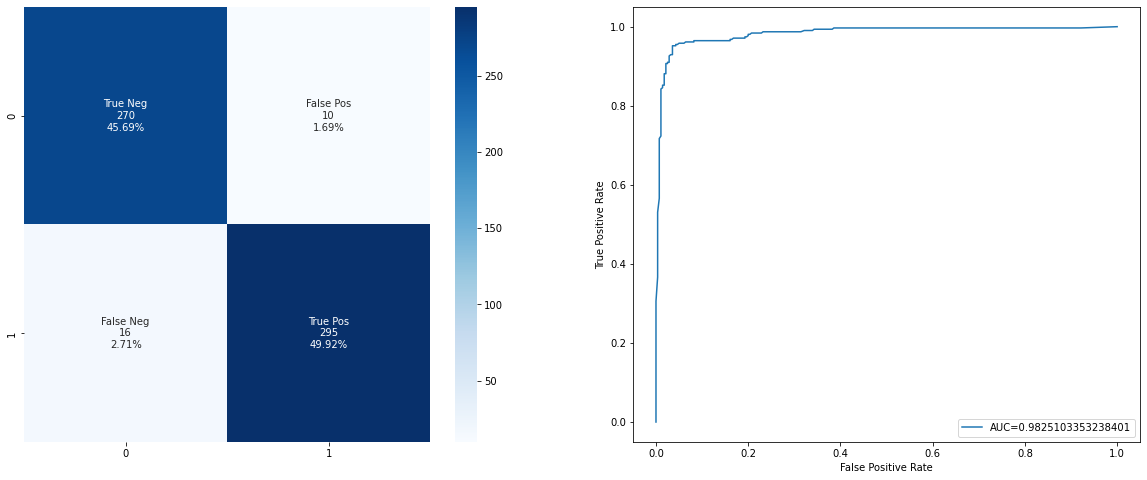

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       280
           1       0.97      0.95      0.96       311

    accuracy                           0.96       591
   macro avg       0.96      0.96      0.96       591
weighted avg       0.96      0.96      0.96       591



In [116]:
top_features = ['kmer6_max', 'lingo5_max', 'smifp34Tan_max', 'adj_kmer2_max', 'NLCS_max', 'comptfidf_mean']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'Ion Channel 1:1 top_features'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [164]:
columns = ['Model','AUPRC', 'AUROC', 'Accuracy']
metricTableClassification = pd.DataFrame(columns=columns)
metricTableClassification

,Model,AUPRC,AUROC,Accuracy


In [165]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, auc
import pandas as pd

Results of KNN

 KNN ...................................

Accuracy: 0.8629441624365483
F1-Score: 0.8656716417910448
AUPRC: 0.9088669990912559
AUROC: 0.9175413412953606
PrecisionClass0: 0.8327759197324415
RecallClass0: 0.8892857142857142
PrecisionClass1: 0.8938356164383562
RecallClass1: 0.8392282958199357


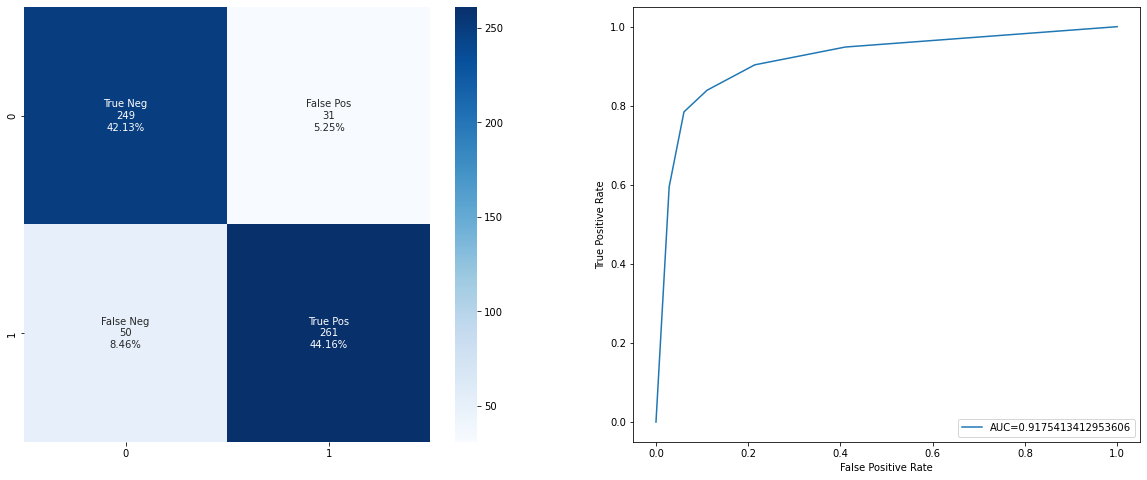

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       280
           1       0.89      0.84      0.87       311

    accuracy                           0.86       591
   macro avg       0.86      0.86      0.86       591
weighted avg       0.86      0.86      0.86       591

Results of Logistic Regression

 Logistic Regression ...................................

Accuracy: 0.8477157360406091
F1-Score: 0.8442906574394463
AUPRC: 0.9352461891756939
AUROC: 0.9232544786403306
PrecisionClass0: 0.7932098765432098
RecallClass0: 0.9178571428571428
PrecisionClass1: 0.9138576779026217
RecallClass1: 0.7845659163987139


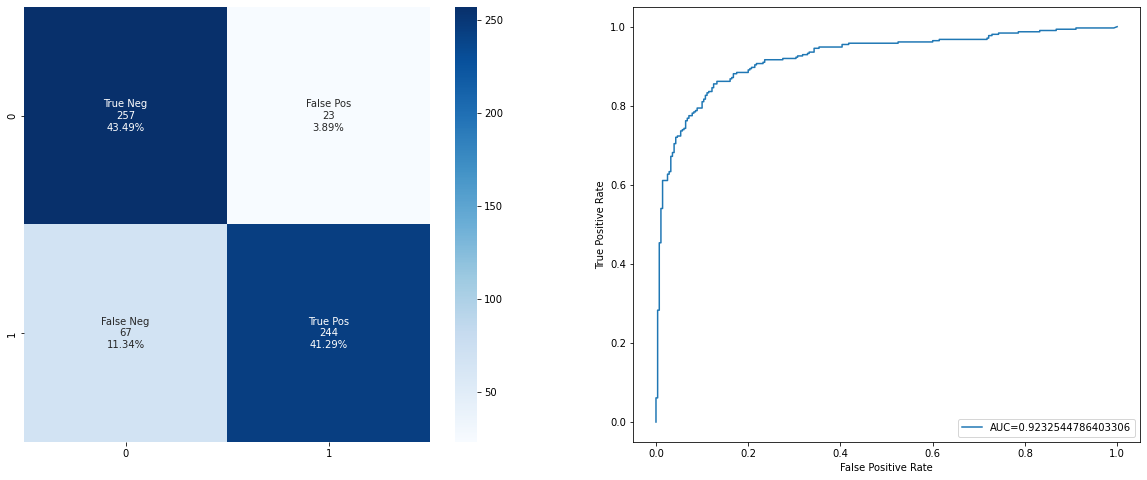

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       280
           1       0.91      0.78      0.84       311

    accuracy                           0.85       591
   macro avg       0.85      0.85      0.85       591
weighted avg       0.86      0.85      0.85       591

Results of MLP Model 1

 MLP Model 1 ...................................

Accuracy: 0.8917089678510999
F1-Score: 0.893687707641196
AUPRC: 0.9683022694377796
AUROC: 0.9607487367937528
PrecisionClass0: 0.86
RecallClass0: 0.9214285714285714
PrecisionClass1: 0.9243986254295533
RecallClass1: 0.864951768488746


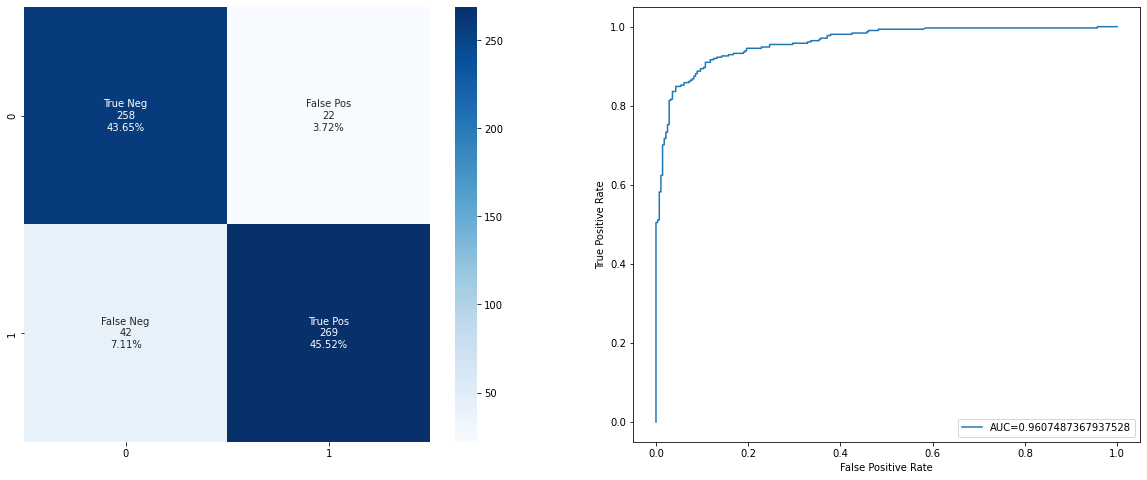

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       280
           1       0.92      0.86      0.89       311

    accuracy                           0.89       591
   macro avg       0.89      0.89      0.89       591
weighted avg       0.89      0.89      0.89       591

Results of MLP Model 2

 MLP Model 2 ...................................

Accuracy: 0.9272419627749577
F1-Score: 0.9293924466338258
AUPRC: 0.9799407856145729
AUROC: 0.97516077170418
PrecisionClass0: 0.9044368600682594
RecallClass0: 0.9464285714285714
PrecisionClass1: 0.9496644295302014
RecallClass1: 0.909967845659164


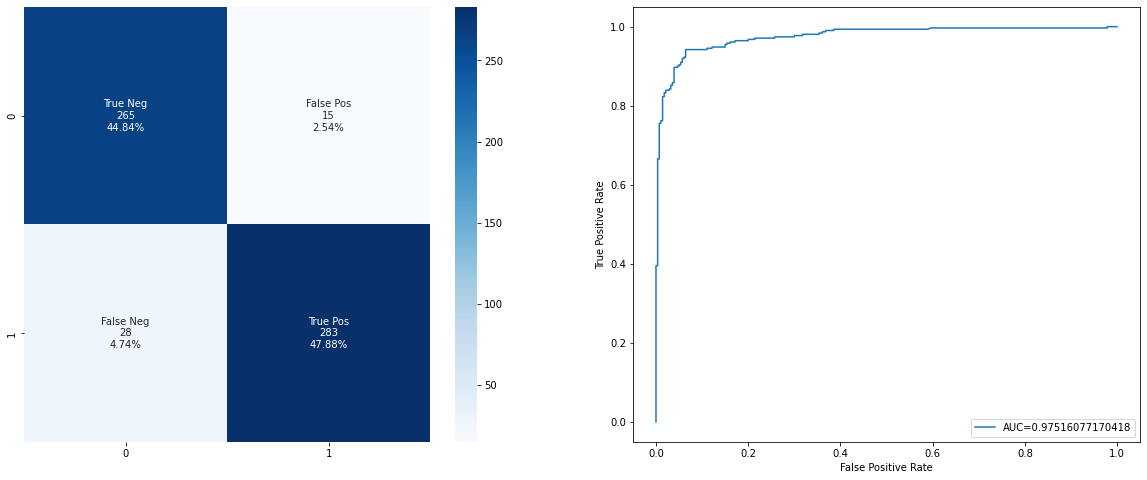

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       280
           1       0.95      0.91      0.93       311

    accuracy                           0.93       591
   macro avg       0.93      0.93      0.93       591
weighted avg       0.93      0.93      0.93       591

Results of Decision Tree

 Decision Tree ...................................

Accuracy: 0.9120135363790186
F1-Score: 0.9174603174603175
AUPRC: 0.8790942275565544
AUROC: 0.9110587965089574
PrecisionClass0: 0.9191176470588235
RecallClass0: 0.8928571428571429
PrecisionClass1: 0.9059561128526645
RecallClass1: 0.9292604501607717


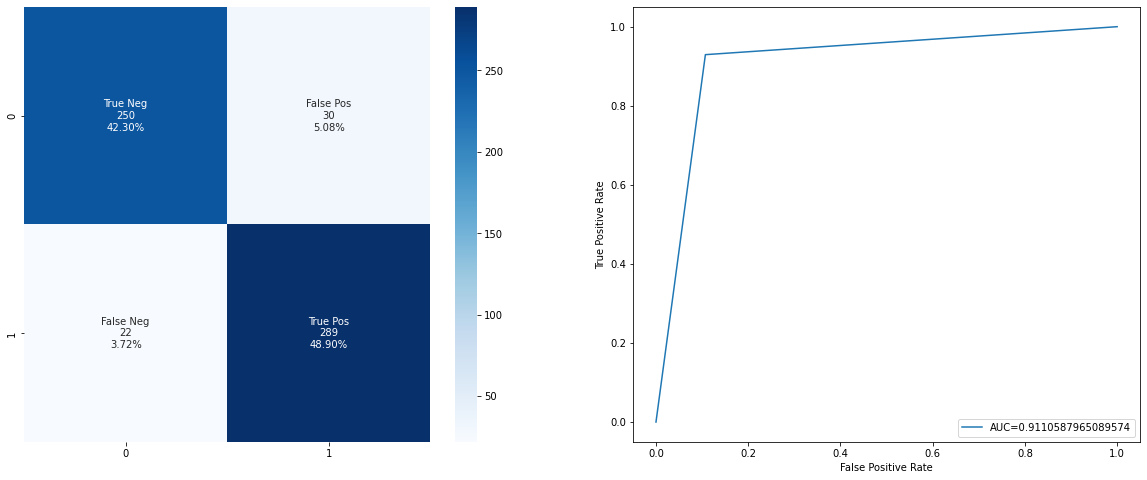

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       280
           1       0.91      0.93      0.92       311

    accuracy                           0.91       591
   macro avg       0.91      0.91      0.91       591
weighted avg       0.91      0.91      0.91       591

Results of Random Forest

 Random Forest ...................................

Accuracy: 0.9509306260575296
F1-Score: 0.9528455284552845
AUPRC: 0.9841477075031576
AUROC: 0.9827055581074873
PrecisionClass0: 0.9372822299651568
RecallClass0: 0.9607142857142857
PrecisionClass1: 0.9638157894736842
RecallClass1: 0.9421221864951769


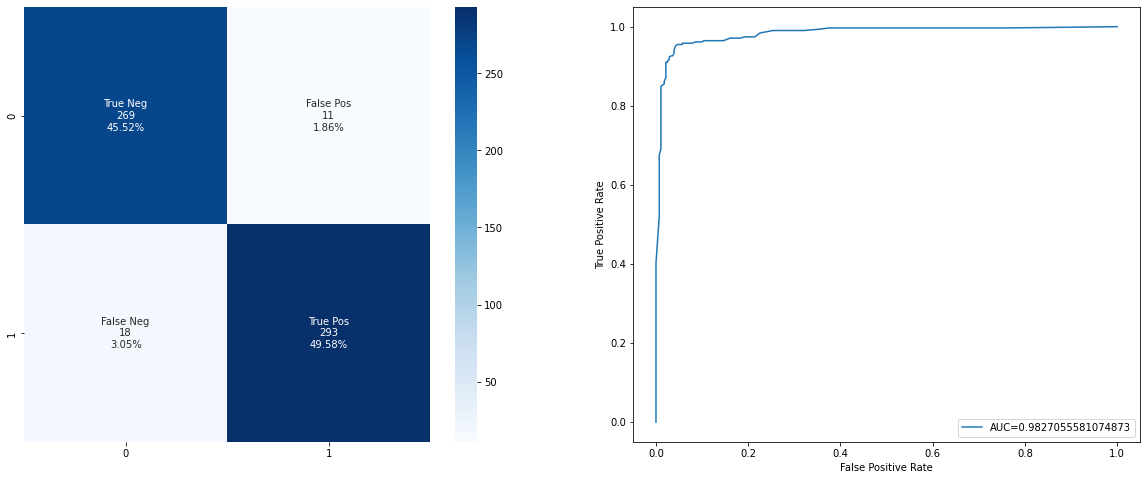

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       280
           1       0.96      0.94      0.95       311

    accuracy                           0.95       591
   macro avg       0.95      0.95      0.95       591
weighted avg       0.95      0.95      0.95       591



,Model,AUPRC,AUROC,Accuracy
0,KNN,0.908867,0.917541,0.862944
1,Logistic Regression,0.935246,0.923254,0.847716
2,MLP Model 1,0.968302,0.960749,0.891709
3,MLP Model 2,0.979941,0.975161,0.927242
4,Decision Tree,0.879094,0.911059,0.912014
5,Random Forest,0.984148,0.982706,0.950931


In [166]:
top_features = ['kmer6_max', 'lingo5_max', 'smifp34Tan_max', 'adj_kmer2_max', 'NLCS_max', 'comptfidf_mean']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)

# List of models to evaluate
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'MLP Model 1': MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42),
    'MLP Model 2': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}




for model_name, model in models.items():
    print(f"Results of {model_name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    auprc, auc_score, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, tp = confusionMat_v2(y_test, y_pred, y_prob,model_name)
    
    # Save results
    df_list = [model_name, auprc, auc_score, accuracy]
    metricTableClassification.loc[len(metricTableClassification)] = df_list

metricTableClassification

**Case Studies**

# 

<a name="3.2"></a>
### Ratio 1:5 
- [Evaluatuin](#3.2.0)
- [Feature Selection](#3.2.1)

In [117]:
# Generate a DataFrame with 2926 random combinations
num_combinations = len(mapping) * 5
df_random = generate_random_combinations(num_combinations, all_drugs, all_targets, mapping)
# Concatenate original DataFrame with the random combinations
mapping_all = pd.concat([mapping.assign(Label=1), df_random], ignore_index=True)
mapping_all = mapping_all.reset_index()
mapping_all

,index,Protein,Drug,Label
0,0,hsa11254,D00035,1
1,1,hsa6534,D00035,1
2,2,hsa11280,D00110,1
3,3,hsa6331,D00110,1
4,4,hsa6336,D00110,1
...,...,...,...,...
8851,8851,hsa1136,D00319,0
8852,8852,hsa7881,D00697,0
8853,8853,hsa2742,D02253,0
8854,8854,hsa3778,D04985,0


In [118]:
#Split Dataset
train_mapping, test_mapping = train_test_split(mapping_all, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [119]:
#Building up an empty dataframe for MiRAGE scores for each drug_disease pair 
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                   'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
                                    "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,   
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer6
                                  'kmer6_max','kmer6_mean',
                                  #Kmer5
                                  'kmer5_max','kmer5_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #Counts
                                  'count_drug','count_target','target'])


for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer6_max = 0
    kmer5_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
#     NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
    comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer6_mean = 0
    kmer5_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
#     NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
    comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    


    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
        comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])     

    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER6
        kmer6_max = max(kmer_6_similarity[kmer_6_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer6_mean = mean(kmer_6_similarity[kmer_6_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER5
        kmer5_max = max(kmer_5_similarity[kmer_5_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer5_mean = mean(kmer_5_similarity[kmer_5_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max  = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())

        
    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
                    comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer6
                    kmer6_max, kmer6_mean,
                    #Kmer5
                    kmer5_max, kmer5_mean,
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_kmer5_max']     = df_scores['count_target'] * df_scores['kmer5_max']
df_scores['adj_kmer6_max']     = df_scores['count_target'] * df_scores['kmer6_max']

df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_comptfidf_max']         = df_scores['count_drug'] * df_scores['comptfidf_max']

df_scores['adj_comptfidf_mean']         = df_scores['count_drug'] * df_scores['comptfidf_mean']

df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_kmer5_mean']     = df_scores['count_target'] * df_scores['kmer5_mean']
df_scores['adj_kmer6_mean']     = df_scores['count_target'] * df_scores['kmer6_mean']


df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']

df_scores

8856it [06:27, 22.84it/s]                                                                                                                                  


,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
0,0,D00035,hsa11254,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,D00035,hsa6534,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,D00110,hsa11280,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,D00110,hsa6331,0.223529,0.155174,0.14942,0.090599,0.405,0.244476,0.21788,...,6.60086,1.04916,5.73904,4.22644,8.230071,4.012904,2.33718,1.654417,1.38655,14.27271
4,4,D00110,hsa6336,0.202128,0.143435,0.13823,0.091206,0.405,0.248691,0.12647,...,5.22251,0.58583,3.82602,3.151351,6.470769,3.008001,1.60801,1.083176,1.23299,11.34735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8851,8851,D00319,hsa1136,0.186275,0.103674,0.12736,0.076727,0.35852,0.219002,0.06039,...,1.97102,0.17355,0.7419,0.988545,2.667909,0.721378,0.31321,0.150234,0.3515,3.86398
8852,8852,D00697,hsa7881,0.164706,0.164706,0.07486,0.07486,0.20833,0.20833,0.00161,...,0.20833,0.00161,0.09249,0.161377,0.3,0.142857,0.03704,0.0,0.05263,0.50754
8853,8853,D02253,hsa2742,0.176471,0.112693,0.0556,0.0458,0.15076,0.129385,0.01933,...,0.51754,0.0399,0.18567,0.136403,0.87324,0.200086,0.06194,0.019241,0.07667,0.99726
8854,8854,D04985,hsa3778,0.1,0.081738,0.09925,0.067294,0.28259,0.18895,0.04882,...,1.32265,0.07015,0.51168,0.246621,1.954493,0.424511,0.15922,0.041241,0.25064,3.33062


In [127]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer6_max', 'kmer6_mean', 'kmer5_max', 'kmer5_mean', 'kmer4_max',
       'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max', 'kmer2_mean',
       'kmer1_max', 'kmer1_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'adj_smile_max',
       'adj_sequence_max', 'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max',
       'adj_kmer4_max', 'adj_kmer5_max', 'adj_kmer6_max',
       'adj_default_protein_max', 'adj_default_compound_max', 'adj_HLCS_max',
       'adj_NLCS_max', 'adj_TFIDF_simmat_max', 'adj_TF_simmat_max',
       'adj_complingo_max', 'adj_edit_max', 'adj_lingo3_max', 'adj_lingo4_max',
       'adj_lingo5_max', 'adj_smifp34Man_max', 'adj_smifp34Tan_max',
       'adj_comptfidf_max', 'adj_comptfidf_mean', 'adj_smile_mean',
       'adj_sequence_mean', 'adj_kmer1_mean', 'adj_kmer2_mean',
       'adj_kmer3_mean', 'adj_kmer4_mean', 'adj_kmer5_mean', 'adj_kmer6_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_edit_mean',
       'adj_lingo3_mean', 'adj_lingo4_mean', 'adj_lingo5_mean',
       'adj_smifp34Man_mean', 'adj_smifp34Tan_mean']

Results of  Ion Channel 1:5

 RandomForest ...................................

Accuracy: 0.9706546275395034
F1-Score: 0.9109589041095891
AUPRC: 0.95555327613865
AUROC: 0.9794239000926702
PrecisionClass0: 0.9706275033377837
RecallClass0: 0.9945280437756497
PrecisionClass1: 0.9708029197080292
RecallClass1: 0.8580645161290322


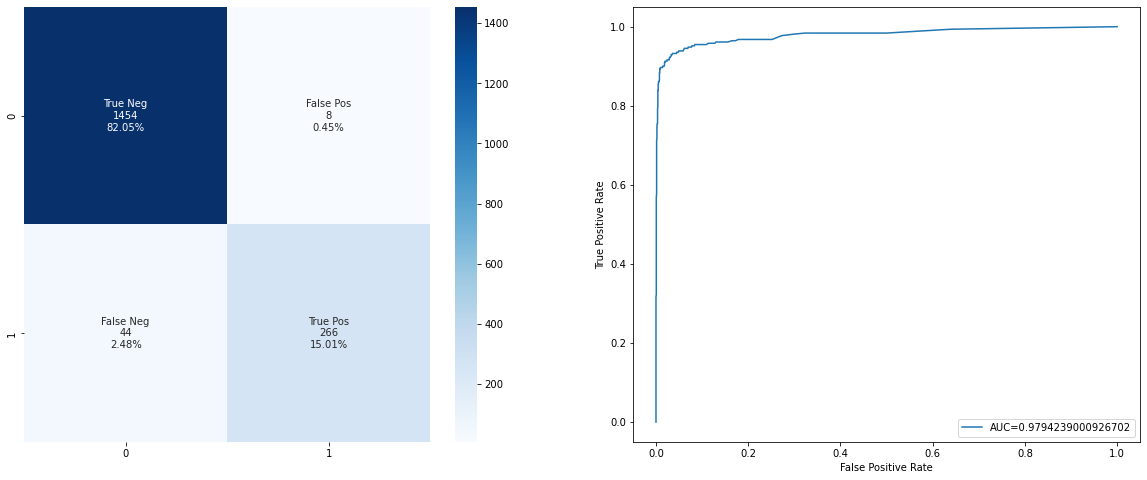

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1462
           1       0.97      0.86      0.91       310

    accuracy                           0.97      1772
   macro avg       0.97      0.93      0.95      1772
weighted avg       0.97      0.97      0.97      1772



In [128]:
# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'Ion Channel 1:5'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [129]:
selected_features = []
best_accuracy = 0  # Start with zero as the best accuracy

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred = rf.predict(X_test[temp_features])

        # Evaluate the model using accuracy
        current_accuracy = accuracy_score(y_test, y_pred)

        # If this model is better, select this feature
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - Accuracy: {best_accuracy}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final = rf_final.predict(X_test[selected_features])

# Evaluate the final model using accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with selected features: {final_accuracy}")

Added feature: kmer4_max - Accuracy: 0.9503386004514672
Added feature: kmer4_mean - Accuracy: 0.9554176072234764
Added feature: edit_max - Accuracy: 0.9621896162528216
Added feature: smifp38Tan_max - Accuracy: 0.9650112866817155
Added feature: adj_sequence_max - Accuracy: 0.9678329571106095
Added feature: default_compound_mean - Accuracy: 0.9706546275395034
Added feature: default_protein_mean - Accuracy: 0.9723476297968398
Added feature: lingo5_max - Accuracy: 0.9734762979683973
Added feature: smile_score_mean - Accuracy: 0.9751693002257337
Added feature: default_protein_max - Accuracy: 0.9757336343115124
Added feature: target_align_score_mean - Accuracy: 0.9762979683972912
Added feature: TF_simmat_mean - Accuracy: 0.9768623024830699
Added feature: adj_smile_mean - Accuracy: 0.9774266365688488
Selected features: ['kmer4_max', 'kmer4_mean', 'edit_max', 'smifp38Tan_max', 'adj_sequence_max', 'default_compound_mean', 'default_protein_mean', 'lingo5_max', 'smile_score_mean', 'default_protei

In [123]:
selected_features

['kmer4_max', 'kmer4_mean', 'edit_max', 'smifp38Tan_max']

Results of  Ion Channel 1:5 topFeatures

 RandomForest ...................................

Accuracy: 0.9774266365688488
F1-Score: 0.9326599326599326
AUPRC: 0.9559028149786413
AUROC: 0.9753419972640219
PrecisionClass0: 0.9778225806451613
RecallClass0: 0.9952120383036935
PrecisionClass1: 0.9753521126760564
RecallClass1: 0.8935483870967742


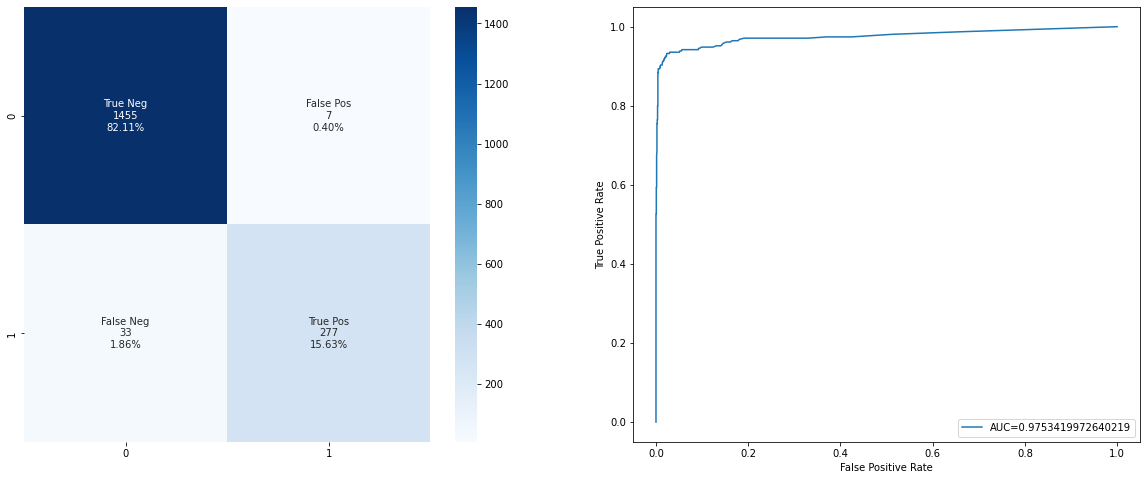

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1462
           1       0.98      0.89      0.93       310

    accuracy                           0.98      1772
   macro avg       0.98      0.94      0.96      1772
weighted avg       0.98      0.98      0.98      1772



In [130]:
topFeatures = ['kmer4_max', 'kmer4_mean', 'edit_max', 'smifp38Tan_max', 
               'adj_sequence_max', 'default_compound_mean', 'default_protein_mean', 'lingo5_max', 'smile_score_mean', 
               'default_protein_max', 'target_align_score_mean', 'TF_simmat_mean', 'adj_smile_mean']
# Split into X_train, y_train, X_test, y_test
X_train = train[topFeatures]
y_train = train['target']
X_test = test[topFeatures]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'Ion Channel 1:5 topFeatures'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

<a name="3.3"></a>
### Ratio 1:10
- [Evaluatuin](#3.3.0)
- [Feature Selection](#3.3.1)

In [131]:
# Generate a DataFrame with 2926 random combinations
num_combinations = len(mapping) * 10
df_random = generate_random_combinations(num_combinations, all_drugs, all_targets, mapping)
# Concatenate original DataFrame with the random combinations
mapping_all = pd.concat([mapping.assign(Label=1), df_random], ignore_index=True)
mapping_all = mapping_all.reset_index()
mapping_all


,index,Protein,Drug,Label
0,0,hsa11254,D00035,1
1,1,hsa6534,D00035,1
2,2,hsa11280,D00110,1
3,3,hsa6331,D00110,1
4,4,hsa6336,D00110,1
...,...,...,...,...
16231,16231,hsa3760,D00704,0
16232,16232,hsa27012,D00530,0
16233,16233,hsa116443,D03450,0
16234,16234,hsa57053,D00338,0


In [132]:
#Split Dataset
train_mapping, test_mapping = train_test_split(mapping_all, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()


In [133]:
#Building up an empty dataframe for MiRAGE scores for each drug_disease pair 
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                   'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
                                    "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,   
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer6
                                  'kmer6_max','kmer6_mean',
                                  #Kmer5
                                  'kmer5_max','kmer5_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #Counts
                                  'count_drug','count_target','target'])


for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer6_max = 0
    kmer5_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
#     NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
    comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer6_mean = 0
    kmer5_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
#     NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
    comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    


    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
        comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])     

    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER6
        kmer6_max = max(kmer_6_similarity[kmer_6_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer6_mean = mean(kmer_6_similarity[kmer_6_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER5
        kmer5_max = max(kmer_5_similarity[kmer_5_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer5_mean = mean(kmer_5_similarity[kmer_5_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max  = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())

        
    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
                    comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer6
                    kmer6_max, kmer6_mean,
                    #Kmer5
                    kmer5_max, kmer5_mean,
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_kmer5_max']     = df_scores['count_target'] * df_scores['kmer5_max']
df_scores['adj_kmer6_max']     = df_scores['count_target'] * df_scores['kmer6_max']

df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_comptfidf_max']         = df_scores['count_drug'] * df_scores['comptfidf_max']

df_scores['adj_comptfidf_mean']         = df_scores['count_drug'] * df_scores['comptfidf_mean']

df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_kmer5_mean']     = df_scores['count_target'] * df_scores['kmer5_mean']
df_scores['adj_kmer6_mean']     = df_scores['count_target'] * df_scores['kmer6_mean']


df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']

df_scores

16236it [13:51, 19.51it/s]                                                                                                                                 


,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
0,0,D00035,hsa11254,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,D00035,hsa6534,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,D00110,hsa11280,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,D00110,hsa6331,0.243243,0.156229,0.14942,0.0911,0.405,0.245088,0.21788,...,6.86247,1.09707,5.95845,4.410471,8.550071,4.269515,2.45248,1.739474,1.45529,14.97251
4,4,D00110,hsa6336,0.202128,0.146729,0.13823,0.088069,0.405,0.238282,0.12647,...,4.76563,0.4693,3.58705,3.013744,6.02,2.774355,1.49222,1.005719,1.18054,10.7532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16231,16231,D00704,hsa3760,0.036364,0.035131,0.05712,0.05624,0.13943,0.138155,0.0137,...,0.27631,0.0137,0.03918,0.09534,0.396723,0.061041,0.01852,0.0,0.07486,0.51676
16232,16232,D00530,hsa27012,0.144444,0.144444,0.07486,0.07486,0.20833,0.20833,0.00465,...,0.20833,0.00465,0.11196,0.140477,0.325,0.068627,0.04762,0.017241,0.04762,0.49405
16233,16233,D03450,hsa116443,0.142857,0.101843,0.10925,0.068717,0.26086,0.182252,0.28467,...,1.09351,0.46688,1.08625,0.77306,1.645162,0.748576,0.41214,0.253323,0.14486,2.21075
16234,16234,D00338,hsa57053,0.17094,0.099766,0.12183,0.064869,0.30083,0.178122,0.09526,...,2.13747,0.21433,1.31377,1.237277,2.892824,0.95956,0.54238,0.266587,0.36925,4.54725


In [141]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer6_max', 'kmer6_mean', 'kmer5_max', 'kmer5_mean', 'kmer4_max',
       'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max', 'kmer2_mean',
       'kmer1_max', 'kmer1_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'adj_smile_max',
       'adj_sequence_max', 'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max',
       'adj_kmer4_max', 'adj_kmer5_max', 'adj_kmer6_max',
       'adj_default_protein_max', 'adj_default_compound_max', 'adj_HLCS_max',
       'adj_NLCS_max', 'adj_TFIDF_simmat_max', 'adj_TF_simmat_max',
       'adj_complingo_max', 'adj_edit_max', 'adj_lingo3_max', 'adj_lingo4_max',
       'adj_lingo5_max', 'adj_smifp34Man_max', 'adj_smifp34Tan_max',
       'adj_comptfidf_max', 'adj_comptfidf_mean', 'adj_smile_mean',
       'adj_sequence_mean', 'adj_kmer1_mean', 'adj_kmer2_mean',
       'adj_kmer3_mean', 'adj_kmer4_mean', 'adj_kmer5_mean', 'adj_kmer6_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_edit_mean',
       'adj_lingo3_mean', 'adj_lingo4_mean', 'adj_lingo5_mean',
       'adj_smifp34Man_mean', 'adj_smifp34Tan_mean']

Results of  Ion Channel 1:10

 RandomForest ...................................

Accuracy: 0.9812192118226601
F1-Score: 0.8872458410351202
AUPRC: 0.9345889086010823
AUROC: 0.9858923276501113
PrecisionClass0: 0.9852892009361418
RecallClass0: 0.9942645074224021
PrecisionClass1: 0.933852140077821
RecallClass1: 0.8450704225352113


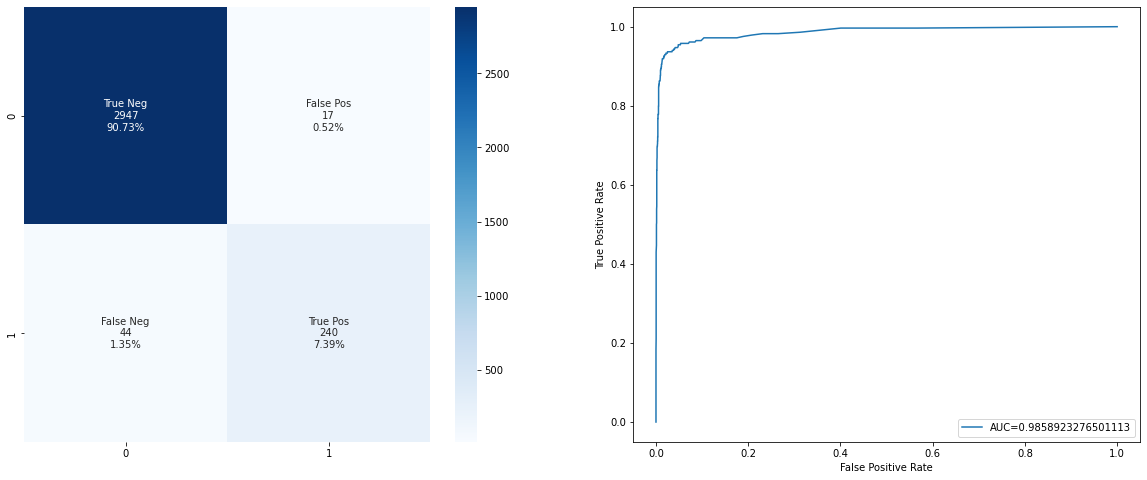

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2964
           1       0.93      0.85      0.89       284

    accuracy                           0.98      3248
   macro avg       0.96      0.92      0.94      3248
weighted avg       0.98      0.98      0.98      3248



In [142]:
# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'Ion Channel 1:10'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

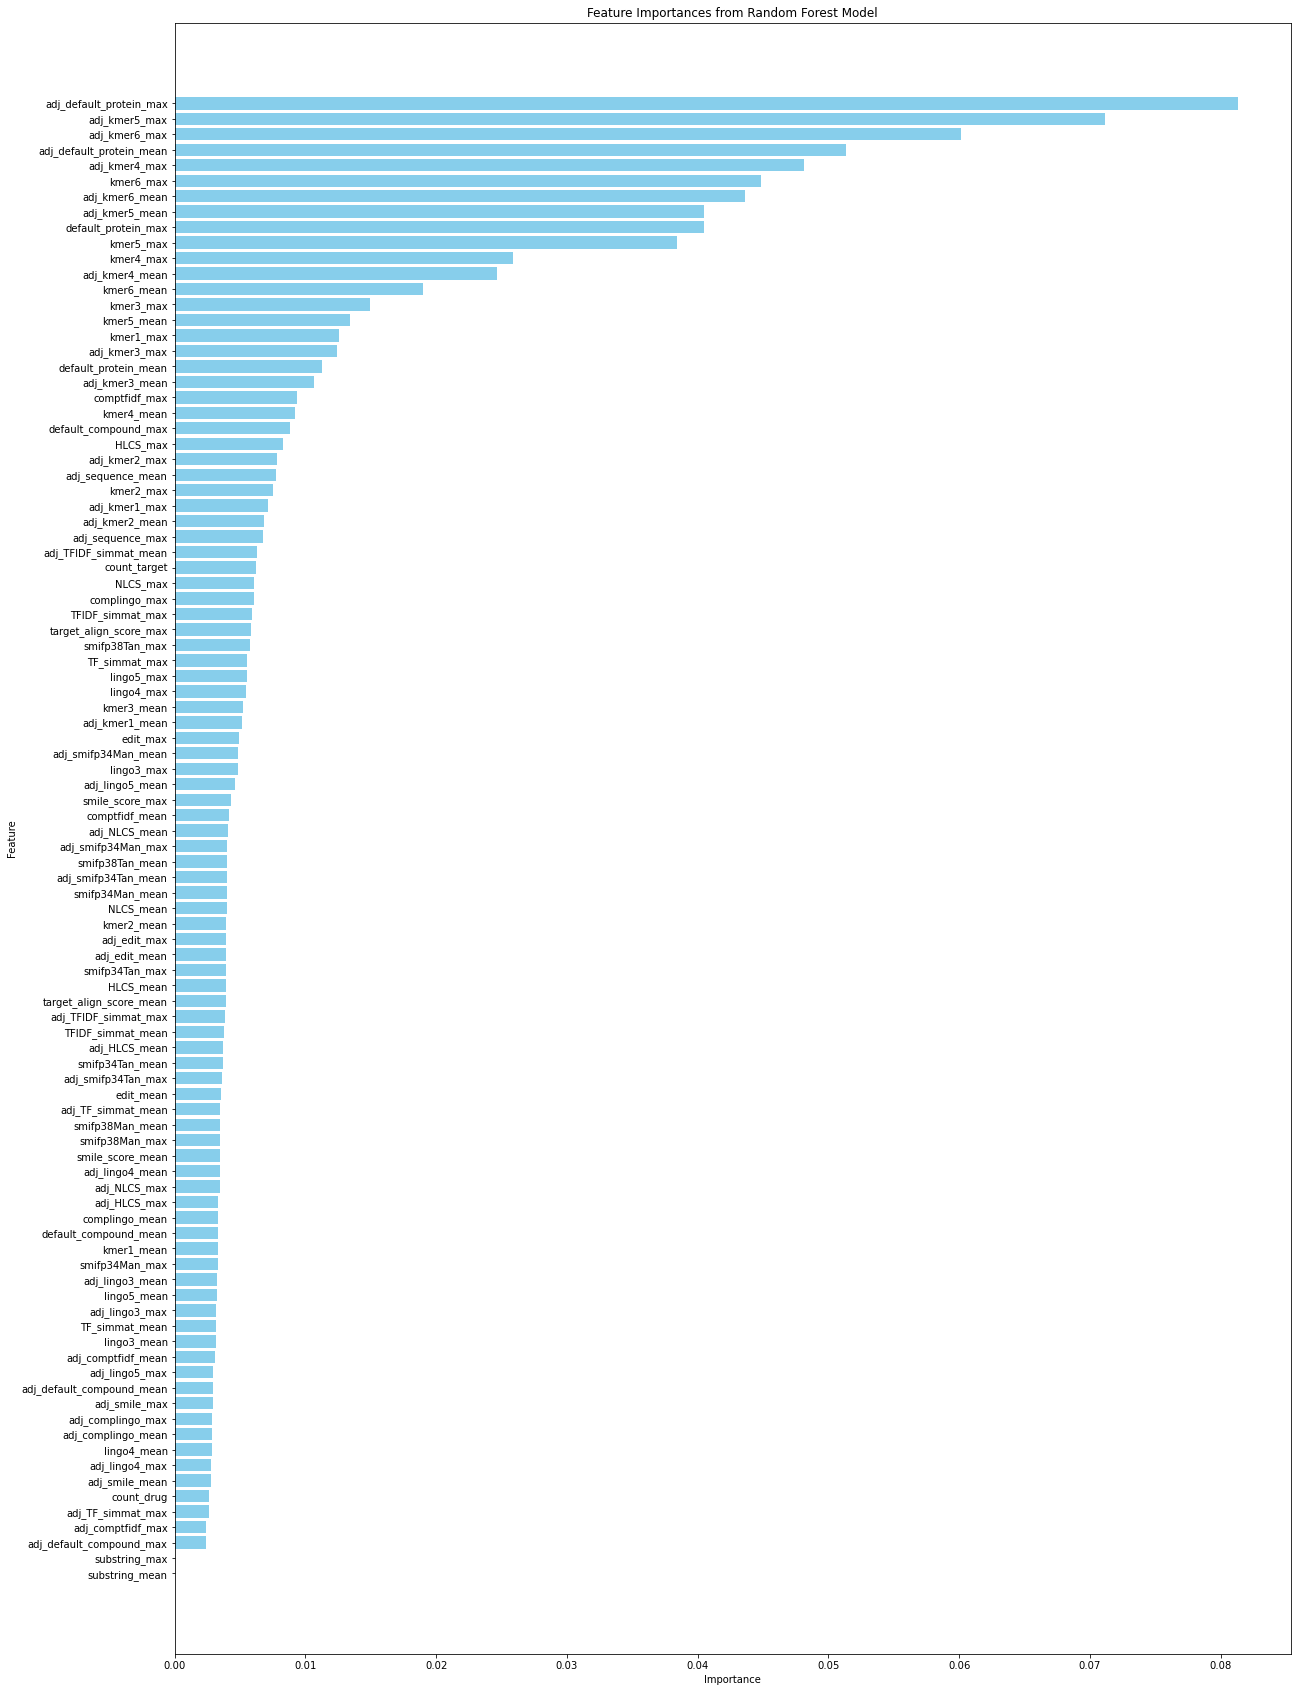

In [143]:
importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(20, 30))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [147]:
feature_importance_df.head(5)['Feature'].tolist()

['adj_default_protein_max',
 'adj_kmer5_max',
 'adj_kmer6_max',
 'adj_default_protein_mean',
 'adj_kmer4_max']

In [153]:
# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


In [154]:
selected_features = []
best_accuracy = 0  # Start with zero as the best accuracy

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred = rf.predict(X_test[temp_features])

        # Evaluate the model using accuracy
        current_accuracy = accuracy_score(y_test, y_pred)

        # If this model is better, select this feature
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - Accuracy: {best_accuracy}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final = rf_final.predict(X_test[selected_features])

# Evaluate the final model using accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with selected features: {final_accuracy}")

Added feature: default_protein_max - Accuracy: 0.9692118226600985
Added feature: adj_kmer3_mean - Accuracy: 0.9738300492610837
Added feature: kmer2_max - Accuracy: 0.9781403940886699
Added feature: TFIDF_simmat_max - Accuracy: 0.9799876847290641
Added feature: comptfidf_mean - Accuracy: 0.9812192118226601
Added feature: default_protein_mean - Accuracy: 0.9821428571428571
Added feature: target_align_score_max - Accuracy: 0.9827586206896551
Added feature: target_align_score_mean - Accuracy: 0.9839901477832512
Selected features: ['default_protein_max', 'adj_kmer3_mean', 'kmer2_max', 'TFIDF_simmat_max', 'comptfidf_mean', 'default_protein_mean', 'target_align_score_max', 'target_align_score_mean']
Final Accuracy with selected features: 0.9839901477832512


Results of  Ion Channel 1:10 topFeatures

 RandomForest ...................................

Accuracy: 0.9839901477832512
F1-Score: 0.9047619047619047
AUPRC: 0.9274065974402665
AUROC: 0.9773146300203379
PrecisionClass0: 0.9876088412592097
RecallClass0: 0.9949392712550608
PrecisionClass1: 0.9427480916030534
RecallClass1: 0.8697183098591549


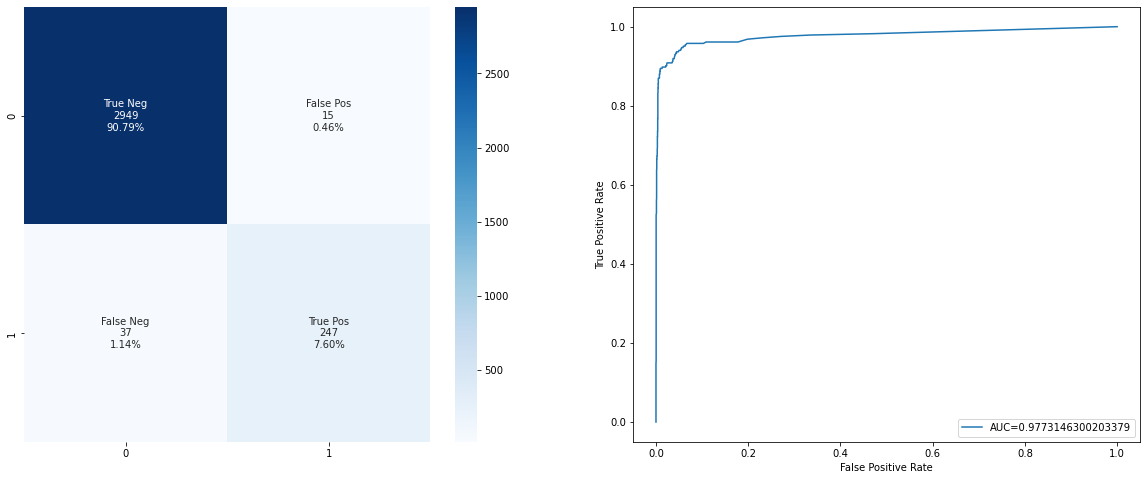

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2964
           1       0.94      0.87      0.90       284

    accuracy                           0.98      3248
   macro avg       0.97      0.93      0.95      3248
weighted avg       0.98      0.98      0.98      3248



In [155]:
topFeatures = ['default_protein_max', 'adj_kmer3_mean', 
               'kmer2_max', 'TFIDF_simmat_max', 
               'comptfidf_mean', 'default_protein_mean', 'target_align_score_max', 'target_align_score_mean']
# Split into X_train, y_train, X_test, y_test
X_train = train[topFeatures]
y_train = train['target']
X_test = test[topFeatures]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'Ion Channel 1:10 topFeatures'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [156]:
metricTable

,Data,AUPRC,AUROC,PrecisionClass0,RecallClass0,PrecisionClass1,RecallClass1,Accuracy,F1
0,Ion Channel 1:1,0.985376,0.979881,0.940141,0.953571,0.957655,0.945338,0.949239,0.951456
1,Ion Channel 1:1 top_features,0.984402,0.982510,0.944056,0.964286,0.967213,0.948553,0.956007,0.957792
2,Ion Channel 1:5,0.955553,0.979424,0.970628,0.994528,0.970803,0.858065,0.970655,0.910959
3,Ion Channel 1:5 topFeatures,0.935781,0.966875,0.968541,0.989740,0.946043,0.848387,0.965011,0.894558
4,Ion Channel 1:5 topFeatures,0.923905,0.959596,0.968435,0.986320,0.929329,0.848387,0.962190,0.887015
5,Ion Channel 1:5,0.955553,0.979424,0.970628,0.994528,0.970803,0.858065,0.970655,0.910959
6,Ion Channel 1:5 topFeatures,0.955903,0.975342,0.977823,0.995212,0.975352,0.893548,0.977427,0.932660
7,Ion Channel 1:10,0.934589,0.985892,0.985289,0.994265,0.933852,0.845070,0.981219,0.887246
8,Ion Channel 1:10 topFeatures(1),0.836626,0.951200,0.979893,0.986505,0.848485,0.788732,0.969212,0.817518
9,Ion Channel 1:10 topFeatures(2),0.918920,0.981840,0.985250,0.991565,0.905660,0.845070,0.978756,0.874317


In [ ]:
features_IC_10 = ['default_protein_max', 'adj_kmer3_mean', 
               'kmer2_max', 'TFIDF_simmat_max', 
               'comptfidf_mean', 'default_protein_mean', 'target_align_score_max', 'target_align_score_mean']

features_IC_5 = ['kmer4_max', 'kmer4_mean', 'edit_max', 'smifp38Tan_max', 
               'adj_sequence_max', 'default_compound_mean', 'default_protein_mean', 'lingo5_max', 'smile_score_mean', 
               'default_protein_max', 'target_align_score_mean', 'TF_simmat_mean', 'adj_smile_mean']

features_IC_1 = ['kmer6_max', 'lingo5_max', 'smifp34Tan_max', 'adj_kmer2_max', 'NLCS_max', 'comptfidf_mean']

## Case Study

In [168]:
mapping

,Protein,Drug
0,hsa11254,D00035
1,hsa6534,D00035
2,hsa11280,D00110
3,hsa6331,D00110
4,hsa6336,D00110
...,...,...
1471,hsa2557,D05461
1472,hsa2558,D05461
1473,hsa2559,D05461
1474,hsa2554,D06106


In [169]:
from itertools import product
# Extract unique proteins and drugs
unique_proteins = mapping['Protein'].unique()
unique_drugs = mapping['Drug'].unique()

# Generate all possible combinations
all_combinations = list(product(unique_proteins, unique_drugs))

# Check if each combination is in the original DataFrame
combination_labels = [
    (protein, drug, 1 if not mapping[(mapping['Protein'] == protein) & (mapping['Drug'] == drug)].empty else 0)
    for protein, drug in all_combinations
]

# Create the new DataFrame
new_df = pd.DataFrame(combination_labels, columns=['Protein', 'Drug', 'Label'])
new_df

,Protein,Drug,Label
0,hsa11254,D00035,1
1,hsa11254,D00110,0
2,hsa11254,D00136,0
3,hsa11254,D00195,0
4,hsa11254,D00219,0
...,...,...,...
42835,hsa1181,D05453,0
42836,hsa1181,D05458,0
42837,hsa1181,D05461,0
42838,hsa1181,D06106,0


In [170]:
new_df['Label'].value_counts()

0    41364
1     1476
Name: Label, dtype: int64

In [171]:
new_df = new_df.reset_index()

In [172]:
unknown  = new_df[new_df['Label'] == 0]
positive = new_df[new_df['Label'] == 1]
#Negative
negative_df = unknown.sample(n=1476 , replace=True, random_state=1)
concatenated_df = pd.concat([positive, negative_df], ignore_index=True)
#Split Dataset
train_mapping, test_mapping = train_test_split(concatenated_df, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [174]:
#Building up an empty dataframe for MiRAGE scores for each drug_disease pair 
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                   'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
                                    "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,   
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer6
                                  'kmer6_max','kmer6_mean',
                                  #Kmer5
                                  'kmer5_max','kmer5_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #Counts
                                  'count_drug','count_target','target'])


for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer6_max = 0
    kmer5_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
#     NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
    comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer6_mean = 0
    kmer5_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
#     NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
    comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    


    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
        comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])     

    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER6
        kmer6_max = max(kmer_6_similarity[kmer_6_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer6_mean = mean(kmer_6_similarity[kmer_6_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER5
        kmer5_max = max(kmer_5_similarity[kmer_5_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer5_mean = mean(kmer_5_similarity[kmer_5_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max  = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())

        
    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
                    comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer6
                    kmer6_max, kmer6_mean,
                    #Kmer5
                    kmer5_max, kmer5_mean,
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_kmer5_max']     = df_scores['count_target'] * df_scores['kmer5_max']
df_scores['adj_kmer6_max']     = df_scores['count_target'] * df_scores['kmer6_max']

df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_comptfidf_max']         = df_scores['count_drug'] * df_scores['comptfidf_max']

df_scores['adj_comptfidf_mean']         = df_scores['count_drug'] * df_scores['comptfidf_mean']

df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_kmer5_mean']     = df_scores['count_target'] * df_scores['kmer5_mean']
df_scores['adj_kmer6_mean']     = df_scores['count_target'] * df_scores['kmer6_mean']


df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']

df_scores

2952it [04:40, 10.52it/s]                                                                                                                                  


,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
0,0,D00035,hsa11254,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,D00035,hsa6534,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,D00110,hsa11280,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,D00110,hsa6331,0.243243,0.153501,0.14942,0.092951,0.405,0.251421,0.21788,...,7.54264,1.19241,6.30739,4.650379,9.310071,4.493466,2.57546,1.810461,1.58968,16.14064
4,4,D00110,hsa6336,0.202128,0.145045,0.13468,0.089797,0.39405,0.239174,0.11903,...,4.30513,0.53764,3.30577,2.825529,5.370769,2.568841,1.40502,0.974124,1.06641,9.67402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,2947,D02409,hsa2900,0.245455,0.245455,0.04499,0.04499,0.13178,0.13178,0.0,...,0.13178,0.0,0.0,0.054054,0.215686,0.02381,0.0,0.0,0.02941,0.34399
2948,2948,D03830,hsa6330,0.28125,0.194066,0.08813,0.070498,0.25606,0.188306,0.20496,...,0.94153,0.31354,1.01215,0.731623,1.2625,0.557359,0.38292,0.228909,0.12974,1.88071
2949,2949,D02566,hsa2566,0.239583,0.158288,0.16825,0.117442,0.43369,0.298363,0.09709,...,2.68527,0.27255,2.04817,1.728355,3.361356,1.120819,0.76826,0.619937,0.54943,3.49549
2950,2950,D05453,hsa6337,0.195652,0.114144,0.14133,0.096796,0.32727,0.246117,0.15274,...,2.21505,0.31479,1.71469,1.127109,3.009972,1.118024,0.7532,0.549441,0.46259,3.75672


In [176]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

Results of  NuclearReceptor 1:5

 RandomForest ...................................

Accuracy: 0.90625
F1-Score: 0.9333333333333332
AUPRC: 0.9884283832109919
AUROC: 0.9749999999999999
PrecisionClass0: 0.8888888888888888
RecallClass0: 0.8
PrecisionClass1: 0.9130434782608695
RecallClass1: 0.9545454545454546


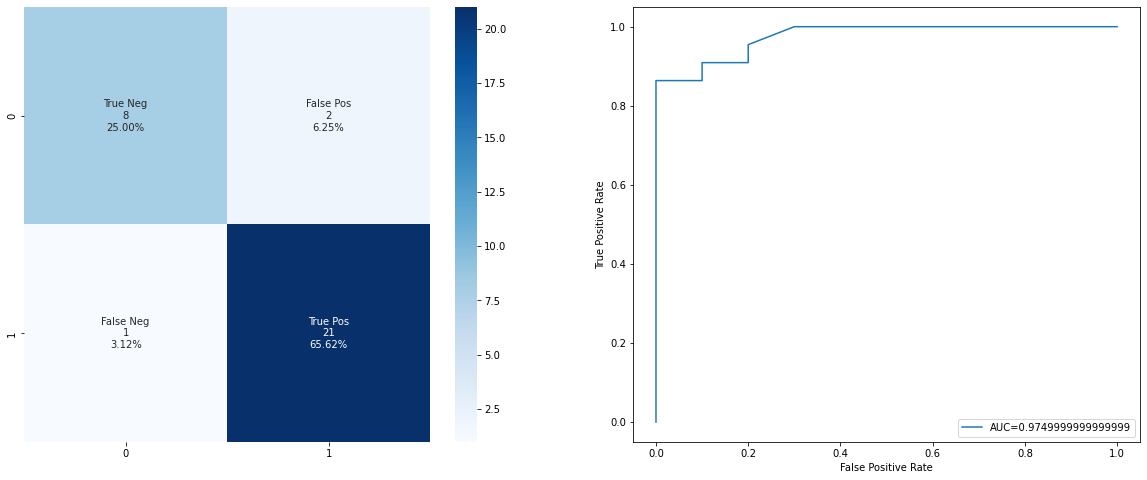

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.91      0.95      0.93        22

    accuracy                           0.91        32
   macro avg       0.90      0.88      0.89        32
weighted avg       0.91      0.91      0.90        32



In [177]:
features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer6_max', 'kmer6_mean', 'kmer5_max', 'kmer5_mean', 'kmer4_max',
       'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max', 'kmer2_mean',
       'kmer1_max', 'kmer1_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'adj_smile_max',
       'adj_sequence_max', 'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max',
       'adj_kmer4_max', 'adj_kmer5_max', 'adj_kmer6_max',
       'adj_default_protein_max', 'adj_default_compound_max', 'adj_HLCS_max',
       'adj_NLCS_max', 'adj_TFIDF_simmat_max', 'adj_TF_simmat_max',
       'adj_complingo_max', 'adj_edit_max', 'adj_lingo3_max', 'adj_lingo4_max',
       'adj_lingo5_max', 'adj_smifp34Man_max', 'adj_smifp34Tan_max',
       'adj_comptfidf_max', 'adj_comptfidf_mean', 'adj_smile_mean',
       'adj_sequence_mean', 'adj_kmer1_mean', 'adj_kmer2_mean',
       'adj_kmer3_mean', 'adj_kmer4_mean', 'adj_kmer5_mean', 'adj_kmer6_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_edit_mean',
       'adj_lingo3_mean', 'adj_lingo4_mean', 'adj_lingo5_mean',
       'adj_smifp34Man_mean', 'adj_smifp34Tan_mean']

# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'NuclearReceptor 1:5'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [178]:
y_prob

array([0.998, 0.992, 0.968, 0.994, 1.   , 0.99 , 0.998, 0.992, 0.6  ,
       0.978, 0.978, 1.   , 0.17 , 0.944, 0.996, 0.992, 1.   , 0.978,
       0.98 , 0.992, 1.   , 0.816, 0.108, 0.17 , 0.112, 0.136, 0.058,
       0.01 , 0.85 , 0.072, 0.06 , 0.668])

In [179]:
unknown_df =  df_scores[df_scores['index'].isin(unknown['index'].tolist())]
unknown_df

,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
1,1,D00035,hsa6534,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,D00110,hsa11280,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,D00110,hsa6331,0.243243,0.153501,0.14942,0.092951,0.405,0.251421,0.21788,...,7.54264,1.19241,6.30739,4.650379,9.310071,4.493466,2.57546,1.810461,1.58968,16.14064
4,4,D00110,hsa6336,0.202128,0.145045,0.13468,0.089797,0.39405,0.239174,0.11903,...,4.30513,0.53764,3.30577,2.825529,5.370769,2.568841,1.40502,0.974124,1.06641,9.67402
5,5,D00110,hsa6529,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,2947,D02409,hsa2900,0.245455,0.245455,0.04499,0.04499,0.13178,0.13178,0.0,...,0.13178,0.0,0.0,0.054054,0.215686,0.02381,0.0,0.0,0.02941,0.34399
2948,2948,D03830,hsa6330,0.28125,0.194066,0.08813,0.070498,0.25606,0.188306,0.20496,...,0.94153,0.31354,1.01215,0.731623,1.2625,0.557359,0.38292,0.228909,0.12974,1.88071
2949,2949,D02566,hsa2566,0.239583,0.158288,0.16825,0.117442,0.43369,0.298363,0.09709,...,2.68527,0.27255,2.04817,1.728355,3.361356,1.120819,0.76826,0.619937,0.54943,3.49549
2950,2950,D05453,hsa6337,0.195652,0.114144,0.14133,0.096796,0.32727,0.246117,0.15274,...,2.21505,0.31479,1.71469,1.127109,3.009972,1.118024,0.7532,0.549441,0.46259,3.75672


In [180]:
# Make predictions
y_prob_unknown = rf.predict_proba(unknown_df[features])[:, 1]
# Create DataFrame with training data and predictions
train_with_predictions = unknown_df.copy()
train_with_predictions['prediction'] = y_prob_unknown

In [182]:
train_with_predictions

,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean,prediction
1,1,D00035,hsa6534,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.764
2,2,D00110,hsa11280,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.978
3,3,D00110,hsa6331,0.243243,0.153501,0.14942,0.092951,0.405,0.251421,0.21788,...,1.19241,6.30739,4.650379,9.310071,4.493466,2.57546,1.810461,1.58968,16.14064,0.992
4,4,D00110,hsa6336,0.202128,0.145045,0.13468,0.089797,0.39405,0.239174,0.11903,...,0.53764,3.30577,2.825529,5.370769,2.568841,1.40502,0.974124,1.06641,9.67402,0.992
5,5,D00110,hsa6529,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,2947,D02409,hsa2900,0.245455,0.245455,0.04499,0.04499,0.13178,0.13178,0.0,...,0.0,0.0,0.054054,0.215686,0.02381,0.0,0.0,0.02941,0.34399,0.142
2948,2948,D03830,hsa6330,0.28125,0.194066,0.08813,0.070498,0.25606,0.188306,0.20496,...,0.31354,1.01215,0.731623,1.2625,0.557359,0.38292,0.228909,0.12974,1.88071,0.042
2949,2949,D02566,hsa2566,0.239583,0.158288,0.16825,0.117442,0.43369,0.298363,0.09709,...,0.27255,2.04817,1.728355,3.361356,1.120819,0.76826,0.619937,0.54943,3.49549,0.438
2950,2950,D05453,hsa6337,0.195652,0.114144,0.14133,0.096796,0.32727,0.246117,0.15274,...,0.31479,1.71469,1.127109,3.009972,1.118024,0.7532,0.549441,0.46259,3.75672,0.156


In [183]:
train_with_predictions.sort_values("prediction",ascending=False).head(20)[["drugID" , "targetID","prediction"]]

,drugID,targetID,prediction
990,D00775,hsa9311,1.0
275,D00349,hsa8913,1.0
958,D00741,hsa6335,1.0
959,D00741,hsa6336,1.0
1426,D04048,hsa6323,1.0
1427,D04048,hsa6326,1.0
294,D00358,hsa6336,1.0
293,D00358,hsa6335,1.0
292,D00358,hsa6334,1.0
291,D00358,hsa6331,1.0
